In [1]:
import numpy as np
from tqdm import tqdm
import glob
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu, ttest_ind, zscore, pearsonr, wilcoxon
import pybedtools as pbt
from scipy.integrate import simps
from IPython.display import clear_output
import pandas as pd
from ipyparallel import Client

plt.style.use('fivethirtyeight')
def clean_axis(ax):
    ax.xaxis.set_tick_params(labelsize=9)
    ax.yaxis.set_tick_params(labelsize=9)
    for i in ['top', 'bottom', 'left', 'right']:
        ax.spines[i].set_visible(False)
    ax.grid(which='major', linestyle='--', alpha=0.5)
    return True

DVIEW = Client()[:]
DVIEW.block=True
len(DVIEW)

30

In [2]:
def calc_stats(chrom):
    import numpy as np
    
    def approx_motifs(a):
        ctr = 0
        cctr = {}
        for i in a:
            if i not in cctr:
                cctr[i] = 0
            cctr[i]+=1
            if cctr[i] == 12:
                cctr[i] = 0
                ctr+=1
        return ctr
    
    num_g = {'positive': [], 'negative': []}
    motifs = {'positive': [], 'negative': []}
    cut_offs = [1, 3, 5, 7, 10, 15, 25, 40, 65, 105, 170, 275, 445, 1000]
    indir = '/home/parashar/scratch/quadcomb/data/sniprq_scores'
    for strand in ['positive', 'negative']:
        fn_in = '%s/%s_%s.npy' % (indir, chrom, strand)
        a = np.load(fn_in)
        nz = a[a > 0]
        for cf in cut_offs:
            b = nz[nz > cf]
            num_g[strand].append(len(b))
            motifs[strand].append(approx_motifs(b))
    return num_g, motifs

chroms = ['chr'+str(x) for x in range(1,23)] + ['chrX', 'chrY']
res = DVIEW.map_sync(calc_stats, chroms)
len(res)

24

In [5]:
cut_offs = [1, 3, 5, 7, 10, 15, 25, 40, 65, 105, 170, 200, 250, 275, 445, 1000]
for i in range(len(cut_offs)):
    num_gs = 0
    num_motifs = 0
    for j in res:
        num_gs += j[0]['positive'][i] + j[0]['negative'][i]
        num_motifs += j[1]['positive'][i] + j[1]['negative'][i]
    print (cut_offs[i], num_gs, num_motifs)

1 325095039 27084083
3 270203795 22509854
5 232585244 19375016
7 190927621 15903595
10 159652890 13297433
15 128403433 10693424
25 86886633 7233917
40 61252796 5098085
65 41506852 3453142
105 26960143 2241802
170 16078752 1336410
200 6900910 573448
250 2872870 238909
275 221083 18402


IndexError: list index out of range

In [4]:
ctrs = {}
spans = {}
gs = {}
for chrom in chroms:
    ctr = 0
    g4_bed = '/home/parashar/scratch/quadruplexes/hg19/g3_25_3_%s_nov.bed' % chrom
    ctr = 0
    span = 0
    g = 0
    with open(g4_bed) as h:
        for l in h:
            c = l.rstrip('\n').split('\t')
            s = int(c[2]) - int(c[1])
            span+=s
            ctr+=1
            g4 = c[5].upper()
            if c[4][0] == "G":
                g+= g4.count('G')
            else:
                g+= g4.count('C')
    gs[chrom] = g
    ctrs[chrom] = ctr
    spans[chrom] = span
    print (chrom, ctr, span, g)

chr1 1321161 85291319 31251140
chr2 1226167 78669321 28509809
chr3 951888 60788075 21859576
chr4 799379 50902253 18179073
chr5 854794 54591512 19621133
chr6 812411 51889073 18703767
chr7 833742 53707659 19586063
chr8 726152 46553563 16836469
chr9 675822 43641806 15955078
chr10 753906 48636568 17733231
chr11 756784 48798204 17883260
chr12 705205 45302129 16481593
chr13 420186 26808138 9609204
chr14 480628 30959662 11276882
chr15 493240 31838111 11653472
chr16 567869 37049266 13774527
chr17 591335 38765191 14532128
chr18 365959 23406491 8449468
chr19 492849 32781196 12505648
chr20 412287 26802015 9924104
chr21 191268 12414207 4548579
chr22 306113 20261111 7668583
chrX 719905 45908775 16415236
chrY 127738 8239484 2921299


In [197]:
sum(list(ctrs.values()))

537072052

In [4]:
chroms = ['chr'+str(x) for x in range(1,23)] + ['chrX', 'chrY']
all_scores = []
for i in tqdm(range(10)):
    temp = []
    for chrom in chroms:
        snipr_score = np.load('../data/sniprq_scores/%s_positive.npy' % chrom,
                                  mmap_mode='r')
        chrom_len = len(snipr_score)
        num_regions = int(chrom_len/1e6)*10
        starts = np.random.randint(0, chrom_len, size=num_regions)
        ends = starts + 100
        for s,e in zip(starts, ends):
            temp.append(snipr_score[s:e])
    all_scores.append(temp)

100%|██████████| 10/10 [00:02<00:00,  3.69it/s]


In [5]:
all_scores = np.array(all_scores)

In [45]:
len(all_scores[0])

2490

In [6]:
all_scores.mean(axis=1).shape

(10, 30890, 100)

In [10]:
a = all_scores.mean(axis=2)
a.shape

(10, 30890)

In [11]:
a[: , :100].shape

(10, 100)

In [17]:
plt.boxplot(a)
plt.show()

KeyboardInterrupt: 

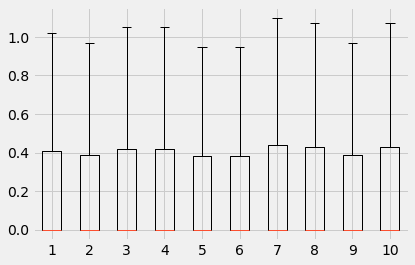

In [15]:
plt.boxplot(a.T, sym='')
plt.show()